# Evaluation and Comparison of TB X-ray Classification Models

In [2]:
# Setup and Import Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

sys.path.append('..')
from attention_model import SimpleAttentionCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Model Paths and Loading

In [3]:
# Define paths
ORIGINAL_MODEL_PATH = "../model/tb_chest_xray_attention_best.pt"
FINETUNED_MODEL_PATH = "../finetuning/tb_chest_xray_refined_20250321_211922.pt"
DATASET_DIR = "../model/tuberculosis-dataset"

# Check if the files and directories exist
print(f"Original model exists: {os.path.exists(ORIGINAL_MODEL_PATH)}")
print(f"Finetuned model exists: {os.path.exists(FINETUNED_MODEL_PATH)}")
print(f"Dataset directory exists: {os.path.exists(DATASET_DIR)}")

# Load model
def load_model(model_path):
    model = SimpleAttentionCNN().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

# Load both models
original_model = load_model(ORIGINAL_MODEL_PATH)
finetuned_model = load_model(FINETUNED_MODEL_PATH)

# Set models to evaluation mode
if original_model:
    original_model.eval()
if finetuned_model:
    finetuned_model.eval()

# Print available directories in the dataset folder to help with navigation
if os.path.exists(DATASET_DIR):
    print(f"\nAvailable directories in dataset folder:")
    for item in os.listdir(DATASET_DIR):
        if os.path.isdir(os.path.join(DATASET_DIR, item)):
            print(f"  - {item}")

Original model exists: True
Finetuned model exists: True
Dataset directory exists: True


C:\Users\dell\AppData\Local\Temp\ipykernel_25076\3306929851.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Successfully loaded model from ../model/tb_chest_xray_attention_best.pt
Successfully loaded model from ../finetuning/tb_chest_xray_refined_20250321_211922.pt

Available directories in dataset folder:
  - Normal
  - Tuberculosis


## 2. Dataset Loading

We'll load the original dataset for evaluation.

In [4]:
class TBXrayDataset(Dataset):
    """Dataset that loads X-ray images for evaluation."""
    def __init__(self, base_dir, transform=None):
        self.transform = transform or T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])
        
        self.filepaths = []
        self.labels = []
        
        # Load normal images (label 0)
        normal_dir = os.path.join(base_dir, "Normal")
        if os.path.isdir(normal_dir):
            for filename in os.listdir(normal_dir):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(normal_dir, filename)
                    if os.path.isfile(path):
                        self.filepaths.append(path)
                        self.labels.append(0)
        
        # Load TB images (label 1)
        tb_dir = os.path.join(base_dir, "Tuberculosis")
        if os.path.isdir(tb_dir):
            for filename in os.listdir(tb_dir):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(tb_dir, filename)
                    if os.path.isfile(path):
                        self.filepaths.append(path)
                        self.labels.append(1)
        
        print(f"Loaded {len(self.filepaths)} images from dataset")
        print(f"Class distribution: {self.labels.count(0)} Normal, {self.labels.count(1)} TB")
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        
        # Read image
        try:
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                raise FileNotFoundError(f"Could not read image: {img_path}")
            
            # Convert to PIL for transforms
            pil_img = Image.fromarray(img_gray, mode='L')
            img_tensor = self.transform(pil_img)
            
            return img_tensor, torch.tensor(label, dtype=torch.float32), img_path
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            # Return empty tensor with same shape
            return torch.zeros(1, 256, 256), torch.tensor(label, dtype=torch.float32), img_path

## 3. Prepare Test Dataset

In [5]:
# Create dataset with test split
def prepare_test_dataset(test_split=0.3, random_seed=42):
    """
    Creates a test dataset that exactly matches the one used during original model training.
    This ensures consistent evaluation between notebooks.
    """
    # Load all images and labels - using the same approach as in tuberculosis-CNN-model.ipynb
    all_images = []
    all_labels = []
    IMAGE_SIZE = 256
    
    normal_dir = os.path.join(DATASET_DIR, "Normal")
    tb_dir = os.path.join(DATASET_DIR, "Tuberculosis")
    
    # Load Normal images (label = 0) - same loading process as original training
    for fname in os.listdir(normal_dir):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        filepath = os.path.join(normal_dir, fname)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            all_images.append(img)
            all_labels.append(0)
    
    # Load Tuberculosis images (label = 1)
    for fname in os.listdir(tb_dir):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        filepath = os.path.join(tb_dir, fname)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            all_images.append(img)
            all_labels.append(1)
    
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    
    print(f"Loaded {len(all_images)} images")
    print(f"Class distribution: {np.sum(all_labels == 0)} Normal, {np.sum(all_labels == 1)} TB")
    
    # Use exact same train_test_split as in the original model training
    # This ensures we're evaluating on the same test data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        all_images, all_labels, test_size=test_split, random_state=random_seed
    )
    
    # Convert from [0,255] -> [0,1] for testing (matching original preprocessing)
    X_test = X_test.astype('float32') / 255.0
    
    # Create a PyTorch dataset from these arrays
    class MatchedTestDataset(Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = images  # Already preprocessed
            self.labels = labels
            self.transform = transform
        
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, idx):
            img = self.images[idx]  # Shape: (H, W)
            label = self.labels[idx]
            
            # Convert to tensor
            if self.transform:
                # Convert to PIL for transforms
                pil_img = Image.fromarray((img * 255).astype('uint8'), mode='L')
                img_tensor = self.transform(pil_img)
            else:
                img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim
            
            # The third return value (path) is required by evaluate_model
            # Since we don't have paths for numpy arrays, we'll create a dummy path
            dummy_path = f"image_{idx:04d}_class_{label}.png"
            
            return img_tensor, torch.tensor(label, dtype=torch.float32), dummy_path
    
    # Create transform matching the one used in original testing
    test_transforms = T.Compose([
        T.ToTensor()  # Images are already resized and normalized
    ])
    
    # Create and return the test dataset
    test_dataset = MatchedTestDataset(X_test, y_test, transform=test_transforms)
    
    print(f"Created test dataset with {len(test_dataset)} images")
    print(f"Class distribution: {np.sum(y_test == 0)} Normal, {np.sum(y_test == 1)} TB")
    
    return test_dataset

# Create test dataset and dataloader
test_dataset = prepare_test_dataset()
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Loaded 4200 images
Class distribution: 3500 Normal, 700 TB
Created test dataset with 1260 images
Class distribution: 1043 Normal, 217 TB


## 4. Model Evaluation Functions

In [6]:
def evaluate_model(model, dataloader, model_name="Model"):
    """Evaluate model and calculate all metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_attn_maps = []
    all_img_paths = []
    
    with torch.no_grad():
        for batch in dataloader:
            images, labels, paths = batch
            images = images.to(device)
            
            # Forward pass
            outputs, attention_maps = model(images)
            
            # Get predictions
            probs = outputs.cpu().numpy().flatten()
            preds = (outputs >= 0.5).cpu().numpy().flatten().astype(int)
            
            # Store results
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            all_attn_maps.extend([attn.cpu().numpy() for attn in attention_maps])
            all_img_paths.extend(paths)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Print metrics
    print(f"\n--- {model_name} Performance Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    results = {
        'preds': all_preds,
        'labels': all_labels,
        'probs': all_probs,
        'attention_maps': all_attn_maps,
        'image_paths': all_img_paths,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'confusion_matrix': cm
        }
    }
    
    return results

## 5. Evaluate Both Models and Calculate Metrics

In [7]:
# Run evaluation for both models
model_results = {}

if original_model:
    print("Evaluating original model on test dataset...")
    model_results['original'] = evaluate_model(original_model, test_dataloader, "Original Model")
else:
    print("Original model not loaded correctly. Cannot evaluate.")

if finetuned_model:
    print("\nEvaluating finetuned model on test dataset...")
    model_results['finetuned'] = evaluate_model(finetuned_model, test_dataloader, "Finetuned Model")
else:
    print("Finetuned model not loaded correctly. Cannot evaluate.")

Evaluating original model on test dataset...

--- Original Model Performance Metrics ---
Accuracy: 0.9794
Precision: 0.9170
Recall: 0.9677
F1 Score: 0.9417
AUC-ROC: 0.9946
Confusion Matrix:
[[1024   19]
 [   7  210]]

Evaluating finetuned model on test dataset...

--- Finetuned Model Performance Metrics ---
Accuracy: 0.9619
Precision: 0.9829
Recall: 0.7926
F1 Score: 0.8776
AUC-ROC: 0.9961
Confusion Matrix:
[[1040    3]
 [  45  172]]


## 6. Visualization of Results

In [8]:
def visualize_confusion_matrix(cm, class_names=['Normal', 'Tuberculosis'], title='Confusion Matrix'):
    """Visualize confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results_dict):
    """Plot ROC curves for multiple models on same graph."""
    plt.figure(figsize=(10, 7))
    
    colors = {'original': 'blue', 'finetuned': 'red'}
    labels = {'original': 'Original Model', 'finetuned': 'Finetuned Model'}
    
    for model_name, results in results_dict.items():
        if model_name in results_dict:
            fpr = results['metrics']['fpr']
            tpr = results['metrics']['tpr']
            roc_auc = results['metrics']['auc']
            color = colors.get(model_name, 'green')
            label = labels.get(model_name, model_name)
            plt.plot(fpr, tpr, color=color, lw=2,
                     label=f'{label} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_comparative_metrics_bar_chart(results_dict):
    """Create side-by-side bar chart comparing metrics between models."""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
    
    # Extract metrics for each model
    metrics_values = {}
    for model_name, results in results_dict.items():
        metrics_values[model_name] = [results['metrics'][metric] for metric in metrics_to_plot]
    
    # Create bar chart
    plt.figure(figsize=(14, 7))
    
    # Set width of bars
    bar_width = 0.35
    index = np.arange(len(metric_labels))
    
    # Create bars
    if 'original' in metrics_values:
        plt.bar(index - bar_width/2, metrics_values['original'], bar_width, 
                label='Original Model', color='cornflowerblue', alpha=0.8)
        
        # Add text labels for original model
        for i, v in enumerate(metrics_values['original']):
            plt.text(i - bar_width/2 - 0.05, v + 0.01, f'{v:.3f}', 
                    color='navy', fontweight='bold', fontsize=9)
    
    if 'finetuned' in metrics_values:
        plt.bar(index + bar_width/2, metrics_values['finetuned'], bar_width,
                label='Finetuned Model', color='lightcoral', alpha=0.8)
        
        # Add text labels for finetuned model
        for i, v in enumerate(metrics_values['finetuned']):
            plt.text(i + bar_width/2 - 0.05, v + 0.01, f'{v:.3f}',
                    color='darkred', fontweight='bold', fontsize=9)
    
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(index, metric_labels)
    plt.ylim(0, 1.1)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


--- Confusion Matrix Visualizations ---


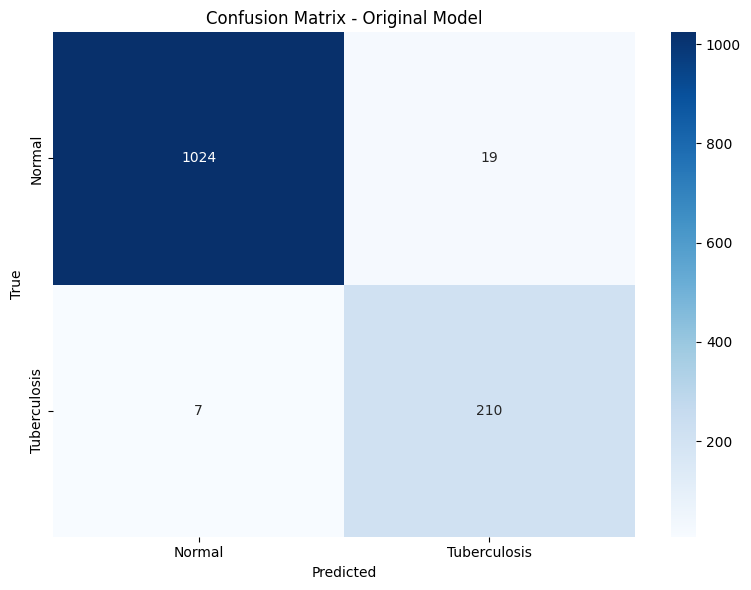

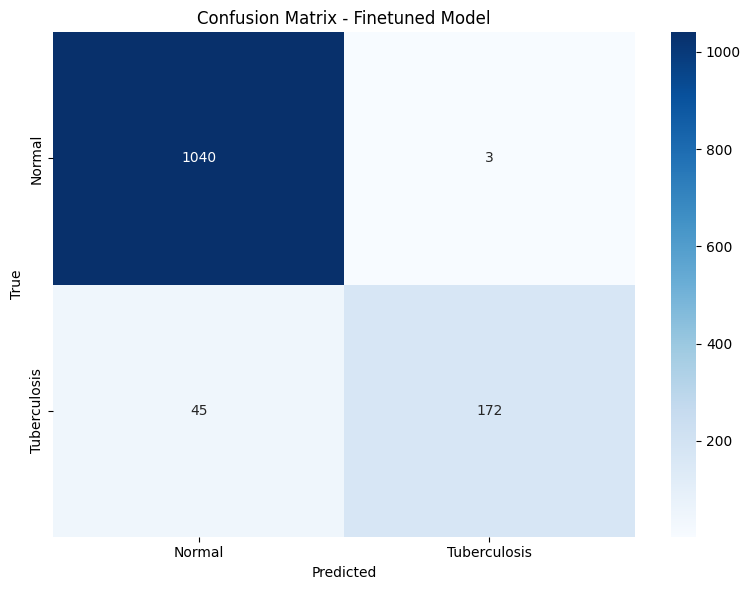


--- ROC Curves Comparison ---


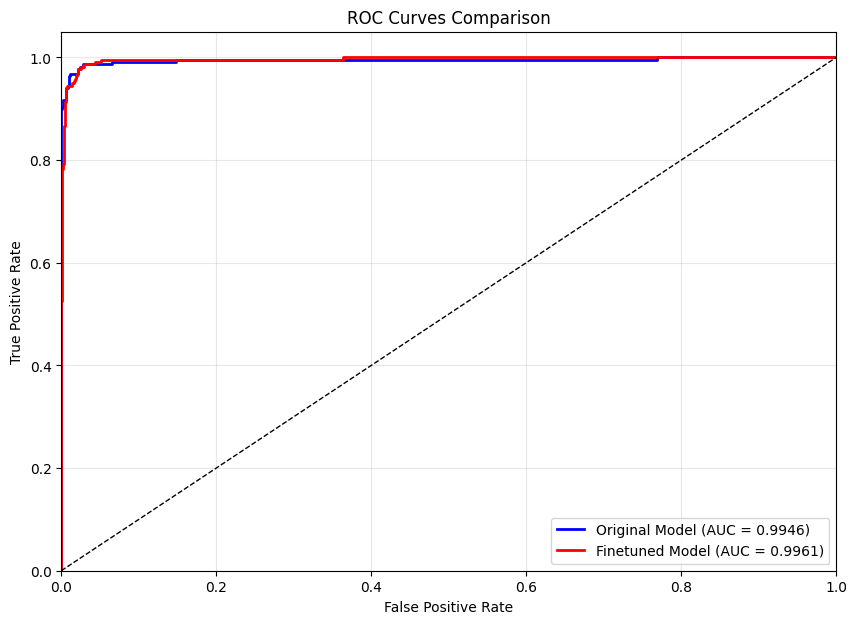


--- Performance Metrics Comparison ---


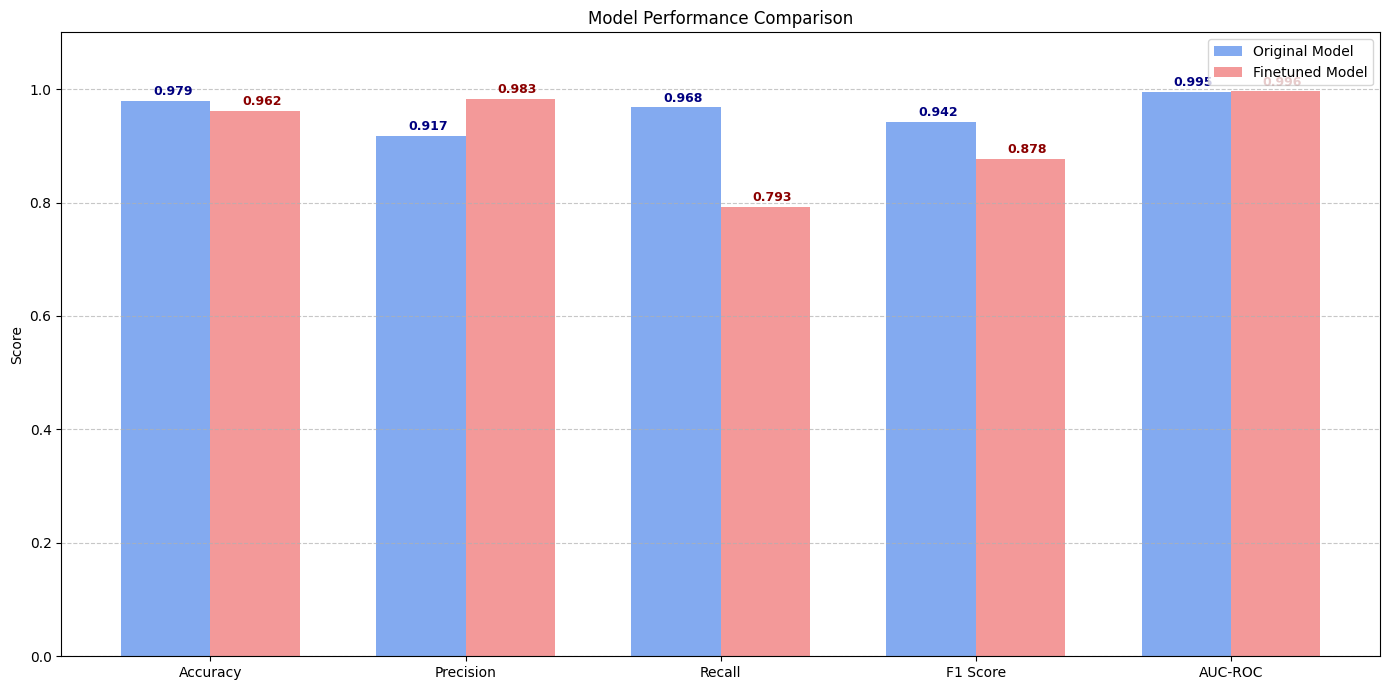

In [9]:
# Visualize results for both models
if len(model_results) > 0:
    # 1. Visualize Confusion Matrices for both models
    print("\n--- Confusion Matrix Visualizations ---")
    
    if 'original' in model_results:
        visualize_confusion_matrix(
            model_results['original']['metrics']['confusion_matrix'],
            title='Confusion Matrix - Original Model'
        )
    
    if 'finetuned' in model_results:
        visualize_confusion_matrix(
            model_results['finetuned']['metrics']['confusion_matrix'],
            title='Confusion Matrix - Finetuned Model'
        )
    
    # 2. Plot comparative ROC Curve
    print("\n--- ROC Curves Comparison ---")
    plot_roc_curves(model_results)
    
    # 3. Plot comparative bar chart of metrics
    print("\n--- Performance Metrics Comparison ---")
    plot_comparative_metrics_bar_chart(model_results)

## 7. Analysis of Errors and Challenging Cases

In [10]:
def compare_errors(results_dict):
    """Compare error patterns between models."""
    if 'original' not in results_dict or 'finetuned' not in results_dict:
        print("Need both models to compare errors.")
        return
        
    orig_preds = results_dict['original']['preds']
    ft_preds = results_dict['finetuned']['preds']
    labels = results_dict['original']['labels']  # Labels are the same for both models
    img_paths = results_dict['original']['image_paths']
    
    # Find indices where models differ in predictions
    diff_indices = [i for i in range(len(orig_preds)) if orig_preds[i] != ft_preds[i]]
    
    # Classification of differences
    improved = [i for i in diff_indices if ft_preds[i] == labels[i] and orig_preds[i] != labels[i]]
    worsened = [i for i in diff_indices if ft_preds[i] != labels[i] and orig_preds[i] == labels[i]]
    
    print(f"Total samples where models differ: {len(diff_indices)}")
    print(f"Improvements (finetuned correct, original wrong): {len(improved)}")
    print(f"Regressions (finetuned wrong, original correct): {len(worsened)}")
    
    # Display examples of improvements
    if improved:
        print("\nExamples of improvements:")
        plt.figure(figsize=(15, 4*min(3, len(improved))))
        
        for i, idx in enumerate(improved[:min(3, len(improved))]):
            img_path = img_paths[idx]
            true_label = "Tuberculosis" if labels[idx] == 1 else "Normal"
            orig_pred = "Tuberculosis" if orig_preds[idx] == 1 else "Normal"
            ft_pred = "Tuberculosis" if ft_preds[idx] == 1 else "Normal"
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                plt.subplot(min(3, len(improved)), 1, i+1)
                plt.imshow(img, cmap='gray')
                plt.title(f"True: {true_label}, Original: {orig_pred}, Finetuned: {ft_pred}\nFile: {os.path.basename(img_path)}")
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Display examples of regressions
    if worsened:
        print("\nExamples of regressions:")
        plt.figure(figsize=(15, 4*min(3, len(worsened))))
        
        for i, idx in enumerate(worsened[:min(3, len(worsened))]):
            img_path = img_paths[idx]
            true_label = "Tuberculosis" if labels[idx] == 1 else "Normal"
            orig_pred = "Tuberculosis" if orig_preds[idx] == 1 else "Normal"
            ft_pred = "Tuberculosis" if ft_preds[idx] == 1 else "Normal"
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                plt.subplot(min(3, len(worsened)), 1, i+1)
                plt.imshow(img, cmap='gray')
                plt.title(f"True: {true_label}, Original: {orig_pred}, Finetuned: {ft_pred}\nFile: {os.path.basename(img_path)}")
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [11]:
# Analyze and compare errors between models
if 'original' in model_results and 'finetuned' in model_results:
    print("\n--- Error Analysis and Comparison ---")
    compare_errors(model_results)
else:
    print("\nNeed both models to compare errors.")


--- Error Analysis and Comparison ---
Total samples where models differ: 58
Improvements (finetuned correct, original wrong): 18
Regressions (finetuned wrong, original correct): 40

Examples of improvements:


<Figure size 1500x1200 with 0 Axes>


Examples of regressions:


<Figure size 1500x1200 with 0 Axes>

## 8. Detailed Classification Reports

In [12]:
# Generate classification reports for both models
if 'original' in model_results:
    # Original model report
    print("\n--- Original Model Classification Report ---")
    orig_report = classification_report(
        model_results['original']['labels'], 
        model_results['original']['preds'],
        target_names=['Normal', 'Tuberculosis']
    )
    print(orig_report)
    
    # Create DataFrame for better visualization
    orig_report_dict = classification_report(
        model_results['original']['labels'],
        model_results['original']['preds'],
        target_names=['Normal', 'Tuberculosis'],
        output_dict=True
    )
    print("Original Model:")
    display(pd.DataFrame(orig_report_dict).transpose().round(4))

if 'finetuned' in model_results:
    # Finetuned model report
    print("\n--- Finetuned Model Classification Report ---")
    ft_report = classification_report(
        model_results['finetuned']['labels'], 
        model_results['finetuned']['preds'],
        target_names=['Normal', 'Tuberculosis']
    )
    print(ft_report)
    
    # Create DataFrame for better visualization
    ft_report_dict = classification_report(
        model_results['finetuned']['labels'],
        model_results['finetuned']['preds'],
        target_names=['Normal', 'Tuberculosis'],
        output_dict=True
    )
    print("Finetuned Model:")
    display(pd.DataFrame(ft_report_dict).transpose().round(4))


--- Original Model Classification Report ---
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      1043
Tuberculosis       0.92      0.97      0.94       217

    accuracy                           0.98      1260
   macro avg       0.96      0.97      0.96      1260
weighted avg       0.98      0.98      0.98      1260

Original Model:


,precision,recall,f1-score,support
Normal,0.9932,0.9818,0.9875,1043.0000
Tuberculosis,0.9170,0.9677,0.9417,217.0000
accuracy,0.9794,0.9794,0.9794,0.9794
macro avg,0.9551,0.9748,0.9646,1260.0000
weighted avg,0.9801,0.9794,0.9796,1260.0000



--- Finetuned Model Classification Report ---
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98      1043
Tuberculosis       0.98      0.79      0.88       217

    accuracy                           0.96      1260
   macro avg       0.97      0.89      0.93      1260
weighted avg       0.96      0.96      0.96      1260

Finetuned Model:


,precision,recall,f1-score,support
Normal,0.9585,0.9971,0.9774,1043.0000
Tuberculosis,0.9829,0.7926,0.8776,217.0000
accuracy,0.9619,0.9619,0.9619,0.9619
macro avg,0.9707,0.8949,0.9275,1260.0000
weighted avg,0.9627,0.9619,0.9602,1260.0000
